# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #2:
- Task 1: Dependencies and OpenAI API Key
- Task 2: LCEL RAG Chain
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset
- Task 6: Evaluation

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for a simple RAG system built on top of LangChain's blogs!

In [13]:
!pip install langchain_core langchain_openai langchain_community langchain-qdrant qdrant-client langsmith openai tiktoken cohere lxml -qU

python(84541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [14]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

#### Asyncio Bug Handling

This is necessary for Colab.

In [15]:
import nest_asyncio
nest_asyncio.apply()

## Task #2: Create a Simple RAG Application Using Qdrant, Hugging Face, and LCEL

Now that we have a grasp on how LCEL works, and how we can use LangChain and Hugging Face to interact with our data - let's step it up a notch and incorporate Qdrant!

## LangChain Powered RAG

First and foremost, LangChain provides a convenient way to store our chunks and their embeddings.

It's called a `VectorStore`!

We'll be using QDrant as our `VectorStore` today. You can read more about it [here](https://qdrant.tech/documentation/).

Think of a `VectorStore` as a smart way to house your chunks and their associated embedding vectors. The implementation of the `VectorStore` also allows for smarter and more efficient search of our embedding vectors - as the method we used above would not scale well as we got into the millions of chunks.

Otherwise, the process remains relatively similar under the hood!

We'll use a SiteMapLoader to scrape the LangChain blogs - which will serve as our data for today!

### Data Collection

We'll be leveraging the `SitemapLoader` to load our PDF directly from the web!

In [16]:
from langchain.document_loaders import SitemapLoader

documents = SitemapLoader(web_path="https://blog.langchain.dev/sitemap-posts.xml").load()

Fetching pages: 100%|##########| 261/261 [00:18<00:00, 14.36it/s]


### Chunking Our Documents

Let's do the same process as we did before with our `RecursiveCharacterTextSplitter` - but this time we'll use ~200 tokens as our max chunk size!

In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 0,
    length_function = len,
)

split_chunks = text_splitter.split_documents(documents)

In [18]:
len(split_chunks)

5585

Alright, now we have 516 ~200 token long documents.

Let's verify the process worked as intended by checking our max document length.

In [19]:
max_chunk_length = 0

for chunk in split_chunks:
  max_chunk_length = max(max_chunk_length, len(chunk.page_content))

print(max_chunk_length)

499


Perfect! Now we can carry on to creating and storing our embeddings.

### Embeddings and Vector Storage

We'll use the `text-embedding-3-small` embedding model again - and `Qdrant` to store all our embedding vectors for easy retrieval later!

In [20]:
from langchain_community.vectorstores import Qdrant
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

qdrant_vectorstore = Qdrant.from_documents(
    documents=split_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Now let's set up our retriever, just as we saw before, but this time using LangChain's simple `as_retriever()` method!

In [21]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

#### Back to the Flow

We're ready to move to the next step!

### Setting up our RAG

We'll use the LCEL we touched on earlier to create a RAG chain.

Let's think through each part:

1. First we need to retrieve context
2. We need to pipe that context to our model
3. We need to parse that output

Let's start by setting up our prompt again, just so it's fresh in our minds!

####🏗️ Activity #2:

Complete the prompt so that your RAG application answers queries based on the context provided, but *does not* answer queries if the context is unrelated to the query.

In [23]:
from langchain.prompts import ChatPromptTemplate

base_rag_prompt_template = """\
Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context response with "I don't know"
"

Context:
{context}

Question:
{question}
"""

base_rag_prompt = ChatPromptTemplate.from_template(base_rag_prompt_template)

We'll set our Generator - `gpt-4o` in this case - below!

In [24]:
from langchain_openai.chat_models import ChatOpenAI

base_llm = ChatOpenAI(model="gpt-4o-mini", tags=["base_llm"])

#### Our RAG Chain

Notice how we have a bit of a more complex chain this time - that's because we want to return our sources with the response.

Let's break down the chain step-by-step:

1. We invoke the chain with the `question` item. Notice how we only need to provide `question` since both the retreiver and the `"question"` object depend on it.
  - We also chain our `"question"` into our `retriever`! This is what ultimately collects the context through Qdrant.
2. We assign our collected context to a `RunnablePassthrough()` from the previous object. This is going to let us simply pass it through to the next step, but still allow us to run that section of the chain.
3. We finally collect our response by chaining our prompt, which expects both a `"question"` and `"context"`, into our `llm`. We also, collect the `"context"` again so we can output it in the final response object.

The key thing to keep in mind here is that we need to pass our context through *after* we've retrieved it - to populate the object in a way that doesn't require us to call it or try and use it for something else.

In [26]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": base_rag_prompt | base_llm, "context": itemgetter("context")}
)

Let's get a visual understanding of our chain!

In [27]:
!pip install -qU grandalf

python(84890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [29]:
print(retrieval_augmented_qa_chain.get_graph().draw_ascii())

          +---------------------------------+      
          | Parallel<context,question>Input |      
          +---------------------------------+      
                    **            **               
                  **                **             
                **                    **           
         +--------+                     **         
         | Lambda |                      *         
         +--------+                      *         
              *                          *         
              *                          *         
              *                          *         
  +----------------------+          +--------+     
  | VectorStoreRetriever |          | Lambda |     
  +----------------------+          +--------+     
                    **            **               
                      **        **                 
                        **    **                   
          +----------------------------------+     
          | 

Let's try another visual representation:

![image](https://i.imgur.com/Ad31AhL.png)

Let's test our chain out!

In [30]:
response = retrieval_augmented_qa_chain.invoke({"question" : "What's new in LangChain v0.2?"})

In [31]:
response["response"].content

'LangChain v0.2 brings several improvements and new features, including:\n\n1. Full separation of langchain and langchain-community.\n2. New (and versioned) documentation.\n3. A more mature and controllable agent framework.\n4. Improved LLM interface standardization, particularly around tool calling.\n5. Streaming support.\n6. 30+ new partner packages.\n\nThis release builds upon the foundation laid in v0.1 and incorporates community feedback.'

In [32]:
for context in response["context"]:
  print("Context:")
  print(context)
  print("----")

Context:
page_content='Four months ago, we released the first stable version of LangChain. Today, we are following up by announcing a pre-release of langchain v0.2.This release builds upon the foundation laid in v0.1 and incorporates community feedback. We’re excited to share that v0.2 brings: A much-desired full separation of langchain and langchain-community New (and versioned!) docs A more mature and controllable agent framework Improved LLM interface standardization, particularly around tool callingBetter' metadata={'source': 'https://blog.langchain.dev/langchain-v02-leap-to-stability/', 'loc': 'https://blog.langchain.dev/langchain-v02-leap-to-stability/', 'lastmod': '2024-05-16T22:26:07.000Z', '_id': '385225ec74e748b58fdcf40fcbaa8828', '_collection_name': '390fbea8853c4864a991789c2eb6f87f'}
----
Context:
page_content='LangChain v0.2: A Leap Towards Stability




















































Skip to content
















Case Studies




In the Loop




LangCha

Let's see if it can handle a query that is totally unrelated to the source documents.

In [33]:
response = retrieval_augmented_qa_chain.invoke({"question" : "What is the airspeed velocity of an unladen swallow?"})

In [34]:
response["response"].content

"I don't know."

## Task 3: Setting Up LangSmith

Now that we have a chain - we're ready to get started with LangSmith!

We're going to go ahead and use the following `env` variables to get our Colab notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [35]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"LangSmith - {unique_id}"

### LangSmith API

In order to use LangSmith - you will need a beta key, you can join the queue through the `Beta Sign Up` button on LangSmith's homepage!

Join [here](https://www.langchain.com/langsmith)

In [36]:
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')

Let's test our our first generation!

In [37]:
retrieval_augmented_qa_chain.invoke({"question" : "What is LangSmith?"}, {"tags" : ["Demo Run"]})['response']

AIMessage(content='LangSmith is a framework built on the shoulders of LangChain, designed to track decisions made by AI models and improve the observability of the development lifecycle. It offers fine-grain controls and customizability through its SDK, allowing users to enhance their AI-powered products and improve their user experiences.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 940, 'total_tokens': 1000, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-2766f2c2-3098-4225-8a9c-57a89c1a8beb-0', usage_metadata={'input_tokens': 940, 'output_tokens': 60, 'total_tokens': 1000, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'ou

## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.

** Answer: **


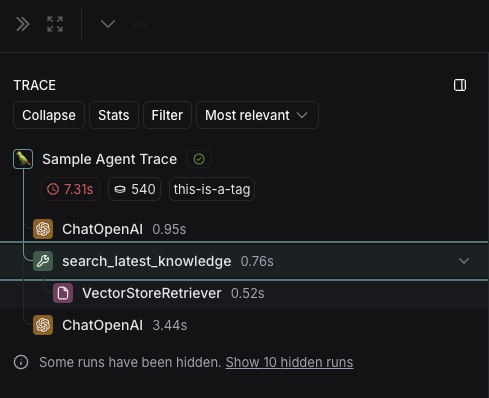

Explaining the trace.

The first node is the ChatOpenAI node. It is the first node in the chain it is the one where the system prompt is set.

The second node is the search_latest_knowledge node. It is the node that searches for the context in the vector store.

The VectorStoreRetriever node is the node that retrieves the context from the vector store.

The fourth step is ChatOpenAI, where the response is generated by the user prompt and the context.

## Task 5: Loading Our Testing Set

In [38]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

Cloning into 'DataRepository'...


python(85415) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 119 (delta 36), reused 40 (delta 10), pack-reused 8 (from 1)
Receiving objects: 100% (119/119), 78.04 MiB | 33.10 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [39]:
import pandas as pd

test_df = pd.read_csv("DataRepository/langchain_blog_test_data.csv")

Now we can set up our LangSmith client - and we'll add the above created dataset to our LangSmith instance!

> NOTE: Read more about this process [here](https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets#create-from-list-of-values)

In [40]:
from langsmith import Client

client = Client()

dataset_name = "langsmith-demo-dataset-aie4-triples-v3"

dataset = client.create_dataset(
    dataset_name=dataset_name, description="LangChain Blog Test Questions"
)

for triplet in test_df.iterrows():
  triplet = triplet[1]
  client.create_example(
      inputs={"question" : triplet["question"], "context": triplet["context"]},
      outputs={"answer" : triplet["answer"]},
      dataset_id=dataset.id
  )

## Task 6: Evaluation

Now we can run the evaluation!

We'll need to start by preparing some custom data preparation functions to ensure our chain works with the expected inputs/outputs from the `evaluate` process in LangSmith.

> NOTE: More reading on this available [here](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#evaluate-a-langchain-runnable)

In [41]:
def prepare_data_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.outputs["answer"],
      "input" : example.inputs["question"]
  }

def prepare_data_noref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "input" : example.inputs["question"]
  }

def prepare_context_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.inputs["context"],
      "input" : example.inputs["question"]
  }

We'll be using a few custom evaluators to evaluate our pipeline, as well as a few "built in" methods!

Check out the built-ins [here](https://docs.smith.langchain.com/reference/sdk_reference/langchain_evaluators)!

In [42]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

eval_llm = ChatOpenAI(model="gpt-4o-mini", tags=["eval_llm"])

cot_qa_evaluator = LangChainStringEvaluator("cot_qa",  config={"llm":eval_llm}, prepare_data=prepare_context_ref)

unlabeled_dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria" : {
            "dopeness" : "Is the answer to the question dope, meaning cool - awesome - and legit?"
        },
        "llm" : eval_llm,
    },
    prepare_data=prepare_data_noref
)

labeled_score_evaluator = LangChainStringEvaluator(
    "labeled_score_string",
    config={
        "criteria": {
            "accuracy": "Is the generated answer the same as the reference answer?"
        },
    },
    prepare_data=prepare_data_ref
)

base_rag_results = evaluate(
    retrieval_augmented_qa_chain.invoke,
    data=dataset_name,
    evaluators=[
        cot_qa_evaluator,
        unlabeled_dopeness_evaluator,
        labeled_score_evaluator,
        ],
    experiment_prefix="Base RAG Evaluation"
)

python(86995) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86996) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86997) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(86999) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87000) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87002) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87004) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(87005) Malloc

View the evaluation results for experiment: 'Base RAG Evaluation-88837d91' at:
https://smith.langchain.com/o/306dc215-46b3-4252-a039-f86d8a073560/datasets/e651739b-e8e7-4565-ab19-bdacc037eb62/compare?selectedSessions=50aada71-7b01-467e-927c-f61aa5a13bc9




0it [00:00, ?it/s]

#### ❓Question #1:

What conclusions can you draw about the above results?

Describe in your own words what the metrics are expressing.

** Answer: **

Here's a summary view of the results

![Screenshot 2025-01-26 at 2.23.28 PM.png](<attachment:Screenshot 2025-01-26 at 2.23.28 PM.png>)

Explaining the results.

The contextual accuracy is strong: 0.8 over 1. This tells me that the app is getting the context right at around 80% of the time.

The dopeness is not strong: 0.48 over 1. Less than 50% of the answers are cool, awesome, and legit.

The accuracy is 6.61 over 10. This tells me that the percentage of correct answers is around 66%.

It is kinda challenging to draw conclusions from the results because I don't have a good benchmark to compare the results to. But if the context accuracy is high but the accuracy of the response is low, it means that the context is not relevant to the question. This tells me that we need to improve the context retrieval process, by expanding the context or bringing in more relevant data.

Contextual accuracy measures the accuracy of the context retrieval process.

Dopeness measures the coolness of the answer. That's something that Dr. Greg would be proud of but with no practical use.

Accuracy measures the accuracy of the response.
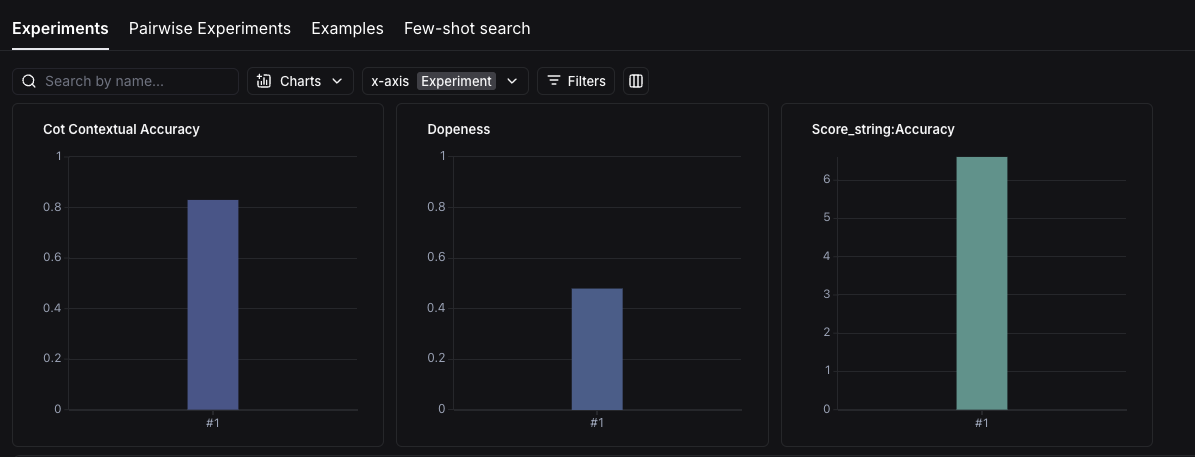